# Обучение полносвязной нейронной сети постановке диагноза на основе 12 отведений ЭКГ

## Импортируем всё необходимое

In [1]:
# Джентльменский набор
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Импортируем простую модель многослойного персептрона Sequential и тип слоя нейронной сети Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

current_directory = os.getcwd() # Сохраняем путь к текущей директории

## Загружаем файлы

In [2]:
def load_func(filename_1, filename_2):
    """
    Загружает данные с двух файлов.

    Parameters:
        filename_1 (str): Путь к npy файлу с записями ЭКГ.
        filename_2 (str): Путь к csv файлу с данными для датасета.

    Returns:
        tuple: Тупль, содержащий X и Y.
    """
    X = np.load(os.path.join(current_directory, filename_1))
    Y = pd.read_csv(os.path.join(current_directory, filename_2), sep=';')
    return X, Y


X, Y = load_func('ecgeq-500hzsrfava.npy', 'coorteeqsrafva.csv')

## Подготавливаем данные

In [3]:
display(Y)

,Unnamed: 0,diagnosi,ecg_id,ritmi,patient_id,age,sex,height,weight,nurse,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,0,STACH,10900,VA,15654.0,54.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
1,1,AFLT,10900,AF,15654.0,54.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
2,2,SR,8209,SR,12281.0,55.0,0,NaN,NaN,1.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/08000/08209_lr,records500/08000/08209_hr
3,3,STACH,17620,VA,2007.0,29.0,1,164.0,56.0,7.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/17000/17620_lr,records500/17000/17620_hr
4,4,SBRAD,12967,VA,8685.0,57.0,0,NaN,NaN,0.0,...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,1,records100/12000/12967_lr,records500/12000/12967_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6423,6423,SARRH,4131,VA,3829.0,81.0,0,178.0,70.0,11.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/04000/04131_lr,records500/04000/04131_hr
6424,6424,STACH,18644,VA,3866.0,88.0,0,152.0,45.0,11.0,...,True,"v3,",NaN,NaN,NaN,2ES,NaN,10,records100/18000/18644_lr,records500/18000/18644_hr
6425,6425,SR,3693,SR,17345.0,83.0,1,NaN,NaN,1.0,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,5,records100/03000/03693_lr,records500/03000/03693_hr
6426,6426,AFIB,1039,AF,6038.0,75.0,1,177.0,80.0,NaN,...,True,NaN,NaN,NaN,NaN,2ES,NaN,7,records100/01000/01039_lr,records500/01000/01039_hr


In [134]:
normalCase = np.array(random.choices(list(Y[Y['ritmi']=='SR'].index), k=510))
data_1 = pd.DataFrame({'index': normalCase, 'class': np.array(list(range(510)))*0})
aritmiaCase = np.array(random.choices(list(Y[Y['ritmi']=='VA'].index), k=510))
data_2 = pd.DataFrame({'index': aritmiaCase, 'class': np.array(list(range(510)))*0+1})
fibrilationCase = np.array(random.choices(list(Y[Y['ritmi']=='AF'].index), k=510))
data_3 = pd.DataFrame({'index': fibrilationCase, 'class': np.array(list(range(510)))*0+2})

data = np.array(pd.merge(left = pd.merge(left = data_1, right = data_2, how = 'outer'),
                 right = data_3, how = 'outer').sample(frac = 1).reset_index(drop=True))

### Нормировка данных

In [135]:
# Нормируем значения входных данных
def norm(x):
    for i in range(x.shape[2]):
        min_x = x[:,:,i].min() # Вычисляем минимальное значение x
        max_x = x[:,:,i].max() - min_x # "Опустим" максимум на min_x
        
        x[:,:,i] = (x[:,:,i]- min_x) / max_x
        x[:,:,i] = x[:,:,i] * 0.99 + 0.01
    return x

def target(y):
    y_target = []
    for i in range(y.shape[0]):
        target = np.zeros(3) + 0.01
        target[y[i]] = 0.99
        y_target.append(target)
    return np.array(y_target)

x_data = norm(X[data[:,0],:2500,:])
y_data = target(data[:,1])

### Распределяем на тренировочную и тестовую выборку

In [136]:
x_train, x_test = (x_data[:1500,:,:], x_data[1500:1530,:,:])
x_train = np.array([x_train[i,:,:].T.flatten() for i in range(x_train.shape[0])])
x_test = np.array([x_test[i,:,:].T.flatten() for i in range(x_test.shape[0])])

y_train, y_test = (y_data[:1500], y_data[1500:1530])

In [137]:
x_train.shape

(1500, 30000)

In [138]:
y_train.shape

(1500, 3)

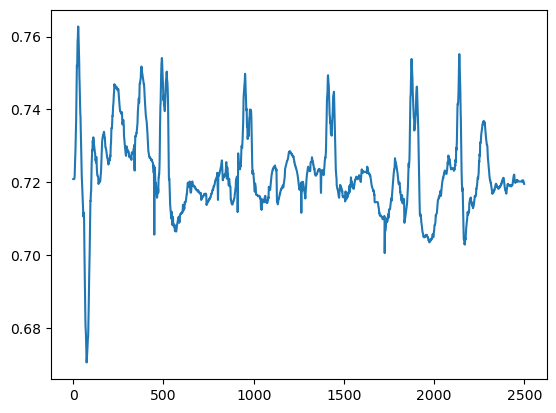

In [139]:
plt.plot(x_train[0,:2500]);

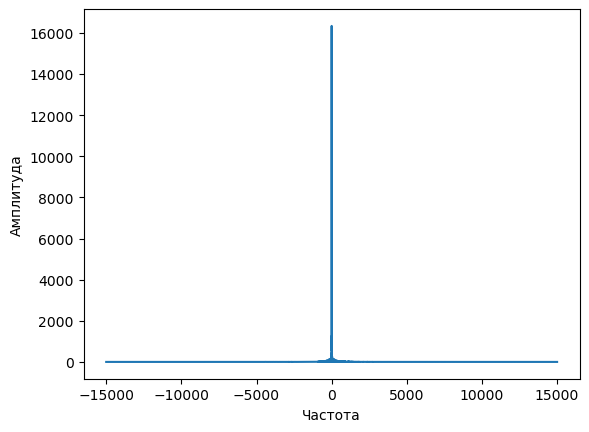

In [140]:
f = np.fft.fft(x_train[0])
fshift = np.fft.fftshift(f)
xf = list(map(lambda x: x - round(len(fshift)/2), list(range(len(fshift)))))
plt.plot(xf, np.abs(fshift))
plt.xlabel('Частота')
plt.ylabel('Амплитуда');

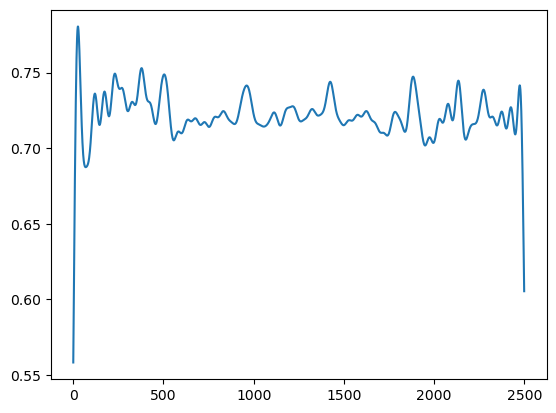

In [141]:
fshift_new = fshift.copy()
fshift_new[:round(len(fshift)/2)-600] = 0
fshift_new[round(len(fshift)/2)+600:] = 0
f_new_ishift = np.fft.ifftshift(fshift_new)
x_back = np.real(np.fft.ifft(f_new_ishift))

plt.plot(x_back[:2500]);

In [142]:
for i in range(x_train.shape[0]):
    f = np.fft.fft(x_train[i])
    fshift = np.fft.fftshift(f)
    fshift_new = fshift.copy()
    fshift_new[:round(len(fshift)/2)-600] = 0
    fshift_new[round(len(fshift)/2)+600:] = 0
    f_new_ishift = np.fft.ifftshift(fshift_new)
    x_train[i] = np.real(np.fft.ifft(f_new_ishift))
    
for i in range(x_test.shape[0]):
    f = np.fft.fft(x_train[i])
    fshift = np.fft.fftshift(f)
    fshift_new = fshift.copy()
    fshift_new[:round(len(fshift)/2)-600] = 0
    fshift_new[round(len(fshift)/2)+600:] = 0
    f_new_ishift = np.fft.ifftshift(fshift_new)
    x_test[i] = np.real(np.fft.ifft(f_new_ishift))

## Создаём модель

In [143]:
model = Sequential() # Делаем переменную model объектом класса Sequential (объект класса нейронных сетей)

# Добавляем к нашей модели слои с заданными размерами, функциями активаций
model.add(Dense(1000, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='sigmoid')) # sigmoid, т.к. данные мы отнормировали выходные данные от 0 до 1

print(model.summary()) # Выводим архитектуру нашей модели

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 1000)              30001000  
                                                                 
 dropout_33 (Dropout)        (None, 1000)              0         
                                                                 
 dense_47 (Dense)            (None, 500)               500500    
                                                                 
 dropout_34 (Dropout)        (None, 500)               0         
                                                                 
 dense_48 (Dense)            (None, 200)               100200    
                                                                 
 dropout_35 (Dropout)        (None, 200)               0         
                                                                 
 dense_49 (Dense)            (None, 3)               

In [144]:
model.compile(optimizer=Adam(learning_rate = 0.01),
              loss='mse',
              metrics=['accuracy'])

In [145]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
47/47 [==============================] - 8s 155ms/step - loss: 0.2711 - accuracy: 0.3393
Epoch 2/5
47/47 [==============================] - 7s 158ms/step - loss: 0.2583 - accuracy: 0.3367
Epoch 3/5
47/47 [==============================] - 7s 157ms/step - loss: 0.2602 - accuracy: 0.3340
Epoch 4/5
47/47 [==============================] - 7s 158ms/step - loss: 0.2589 - accuracy: 0.3407
Epoch 5/5
47/47 [==============================] - 7s 160ms/step - loss: 0.2581 - accuracy: 0.3353


In [146]:
y_pred = model.predict(x_test)

1/1 [==============================] - 0s 62ms/step


In [147]:
y_pred

array([[2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.9452399e-05, 3.4343567e-01],
       [2.4745370e-01, 5.945

In [148]:
y_test

array([[0.01, 0.99, 0.01],
       [0.99, 0.01, 0.01],
       [0.99, 0.01, 0.01],
       [0.01, 0.01, 0.99],
       [0.01, 0.01, 0.99],
       [0.01, 0.99, 0.01],
       [0.01, 0.01, 0.99],
       [0.01, 0.99, 0.01],
       [0.01, 0.01, 0.99],
       [0.01, 0.99, 0.01],
       [0.01, 0.99, 0.01],
       [0.99, 0.01, 0.01],
       [0.99, 0.01, 0.01],
       [0.01, 0.01, 0.99],
       [0.01, 0.99, 0.01],
       [0.01, 0.99, 0.01],
       [0.99, 0.01, 0.01],
       [0.01, 0.99, 0.01],
       [0.01, 0.99, 0.01],
       [0.99, 0.01, 0.01],
       [0.01, 0.01, 0.99],
       [0.99, 0.01, 0.01],
       [0.01, 0.01, 0.99],
       [0.01, 0.01, 0.99],
       [0.01, 0.99, 0.01],
       [0.01, 0.01, 0.99],
       [0.01, 0.99, 0.01],
       [0.01, 0.99, 0.01],
       [0.99, 0.01, 0.01],
       [0.99, 0.01, 0.01]])